In [ ]:
import pandas as pd
import numpy as np
import os
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # 진행바

# === ① 호선별 정보(역명, 칸수, 맵) ===
station_name = {
    "1호선": ["서울역","시청","종각","종로3가","종로5가","동대문","신설동","제기동","청량리","동묘앞"],
    "2호선": ["시청","을지로입구","을지로3가","을지로4가","동대문역사문화공원","신당","상왕십리",
               "왕십리","한양대","뚝섬","성수","건대입구","구의","강변","잠실나루","잠실","잠실새내",
               "종합운동장","삼성","선릉","역삼","강남","교대","서초","방배","사당","낙성대","서울대입구",
               "봉천","신림","신대방","구로디지털단지","대림","신도림","문래","영등포구청","당산","합정",
               "홍대입구","신촌(지하)","이대","아현","충정로","용답","신답","신설동","도림천","양천구청",
               "신정네거리","용두"],
    "3호선": ["지축","구파발","연신내","불광","녹번","홍제","무악재","독립문","경복궁","안국","종로3가",
               "을지로3가","충무로","동대입구","약수","금호","옥수","압구정","신사","잠원","고속터미널",
               "교대","남부터미널","양재","매봉","도곡","대치","학여울","대청","일원","수서","가락시장",
               "경찰병원","오금"],
    "4호선": ["상계","노원","창동","쌍문","수유","미아","미아삼거리","길음","성신여대입구","한성대입구",
               "혜화","동대문","동대문역사문화공원","충무로","명동","회현","서울역","숙대입구",
               "삼각지","신용산","이촌","동작","총신대입구","사당","남태령"],
    "5호선": ["개화산","김포공항","송정","마곡","발산","우장산","화곡","까치산","신정","목동","오목교",
               "양평","영등포구청","영등포시장","신길","여의도","여의나루","마포","공덕","애오개",
               "충정로","서대문","광화문","종로3가","을지로4가","동대문역사문화공원",
               "청구","신금호","행당","왕십리","마장","답십리","장한평","군자","아차산","광나루","천호",
               "강동","길동","굽은다리","명일","고덕","상일동","둔촌동","올림픽공원(한국체대)",
               "방이","오금","개롱","거여","마천","강일","미사","하남풍산","하남시청","하남검단산"],
    "6호선": ["응암","새절","증산","디지털미디어시티","월드컵경기장","마포구청","망원","합정",
               "상수","광흥창","대흥","공덕","효창공원앞","삼각지","녹사평","이태원","한강진",
               "버티고개","약수","청구","신당","동묘앞","창신","보문","안암","고려대","월곡",
               "상월곡","돌곶이","석계","태릉입구","화랑대","봉화산","신내"],
    "7호선": ["도봉산","수락산","마들","노원","중계","하계","공릉","태릉입구","먹골","중화","상봉",
               "면목","사가정","용마산","중곡","군자","어린이대공원","건대입구","자양(뚝섬한강공원)",
               "청담","강남구청","학동","논현","반포","고속터미널","내방","총신대입구","남성","숭실대입구",
               "상도","장승배기","신대방삼거리","보라매","신풍","대림","남구로","가산디지털단지",
               "철산","광명사거리","천왕","온수"],
    "8호선": ["천호","강동구청","몽촌토성","잠실","석촌","송파","가락시장","문정","장지","복정",
               "산성","남한산성입구","단대오거리","신흥","수진","모란"]
}
hosun_car_count = {
    "1호선": 10, "2호선": 10, "3호선": 10, "4호선": 10,
    "5호선": 8,  "6호선": 8,  "7호선": 8,  "8호선": 6
}
station_time = [i for i in range(5,24)] + [0]  # 5~23, 0
weekday_map = {"월요일":0,"화요일":1,"수요일":2,"목요일":3,"금요일":4,"토요일":5,"일요일":6}
weektype_list = [0,1]  # 0:평일, 1:주말

# === ② 경로 세팅 ===
DATA_DIR = r"C:\Users\user\Desktop\project\metrosafe\model\data\api_데이터"
OUTPUT_DIR = r"C:\Users\user\Desktop\project\metrosafe\model\data\test_출력"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === ③ 전체 노선 반복 ===
total_result_rows = []

for hosun in tqdm(station_name.keys()):
    print(f"[{hosun}] 처리 시작")
    loss_path = os.path.join(DATA_DIR, f"날짜합친{hosun}.csv")
    if not os.path.exists(loss_path):
        print("데이터 미존재:", loss_path)
        continue

    df = pd.read_csv(loss_path, encoding="euc-kr")

    # --- 요일 변환 및 '평일주말' 컬럼 추가 ---
    df["요일num"] = df["요일(한글)"].map(weekday_map)
    df["평일주말"] = df["요일num"].apply(lambda x: 0 if x<5 else 1)

    # --- 칸별 혼잡도 열 생성 ---
    car_count = hosun_car_count[hosun]
    def list_to_cols(row):
        l = eval(row["congestionCar"])
        for i in range(car_count):
            row[f"Car_{i+1}"] = l[i] if i < len(l) else 0
        return row
    df = df.apply(list_to_cols, axis=1)

    # --- 역명 LabelEncoding (노선별) ---
    le_station = LabelEncoder()
    df["station_code"] = le_station.fit_transform(df["역명"])
    feature_codes = ["station_code", "시간", "상하행", "평일주말"]
    target_cols = [f"Car_{i+1}" for i in range(car_count)]

    # --- ML 모델 학습 ---
    X, Y = df[feature_codes], df[target_cols]
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.1, random_state=hosun.__hash__()%9999
    )
    model = RandomForestRegressor(n_estimators=120, random_state=111)
    model.fit(X_train, y_train)
    print(f"{hosun} score:", model.score(X_test, y_test))

    # --- 모든 조합 예측 및 저장 ---
    station_list = le_station.classes_
    time_list = station_time
    direction_list = [0, 1]  # 0:하행, 1:상행

    all_cases = list(itertools.product(station_list, time_list, direction_list, weektype_list))
    result_rows = []
    for station, hour, direction, weektype in all_cases:
        st_code = le_station.transform([station])[0]
        input_vec = [[st_code, hour, direction, weektype]]
        pred = model.predict(input_vec)[0]
        pred = np.round(pred).astype(int).tolist()
        best_car = int(np.argmin(pred)) + 1

        result_rows.append({
            "호선":hosun,
            "역명":station,
            "시간":hour,
            "상하행":direction,
            "평일주말":weektype,
            "혼잡도리스트":str(pred),
            "추천칸":best_car
        })

    result_df = pd.DataFrame(result_rows)
    result_df.to_csv(os.path.join(OUTPUT_DIR, f"{hosun}_혼잡도예측_전체케이스.csv"), index=False, encoding="utf-8-sig")
    total_result_rows.extend(result_rows)

# --- 전체 합본 저장 ---
all_result_df = pd.DataFrame(total_result_rows)
all_result_df.to_csv(os.path.join(OUTPUT_DIR, "혼잡도예측_전체케이스.csv"), index=False, encoding="utf-8-sig")
print("완료! 전체 케이스는", os.path.join(OUTPUT_DIR, "혼잡도예측_전체케이스.csv"), "에 저장됩니다.")


  0%|          | 0/8 [00:00<?, ?it/s]

[1호선] 처리 시작
1호선 score: 0.7011546704467125


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

[2호선] 처리 시작
데이터 미존재: C:\Users\user\Desktop\project\metrosafe\model\data\api_데이터\날짜합친2호선.csv
[3호선] 처리 시작
3호선 score: 0.8407671472690412


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

[4호선] 처리 시작
4호선 score: 0.8337135912149851


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

[5호선] 처리 시작


C:\Users\user\AppData\Local\Temp\ipykernel_15084\3824471652.py:67: DtypeWarning: Columns (2,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding="euc-kr")


5호선 score: 0.8896293660756173


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

[6호선] 처리 시작
6호선 score: 0.8900690205140445


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

[7호선] 처리 시작
데이터 미존재: C:\Users\user\Desktop\project\metrosafe\model\data\api_데이터\날짜합친7호선.csv
[8호선] 처리 시작
8호선 score: 0.9140172790037884


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

완료! 전체 케이스는 C:\Users\user\metrosafe-1\model\data\test_출력\혼잡도예측_전체케이스.csv 에 저장됩니다.


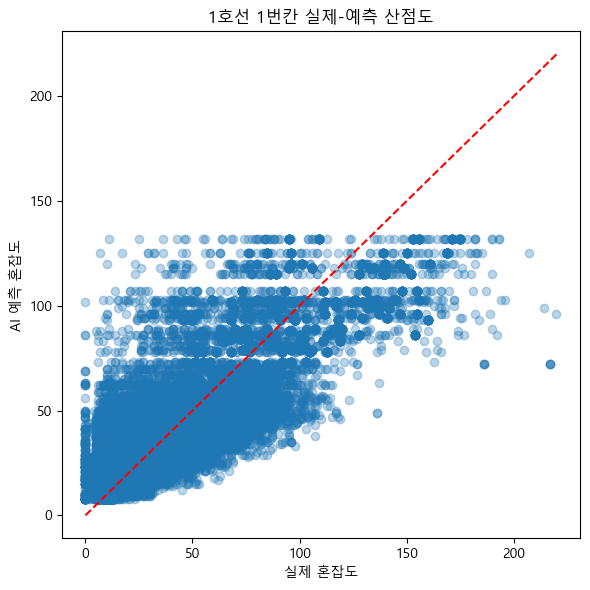

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'  # '맑은 고딕' 폰트 지정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호(-) 정상 출력

real_path = r"C:\Users\user\Desktop\project\metrosafe\model\data\api_데이터\날짜합친1호선.csv"
pred_path = r"C:\Users\user\Desktop\project\metrosafe\model\data\test_출력\1호선_혼잡도예측_전체케이스.csv"
loss_path = r'C:\Users\user\Desktop\project\metrosafe\model\loss2/1호선_loss_result.csv'

real_df = pd.read_csv(real_path, encoding='euc-kr')
pred_df = pd.read_csv(pred_path, encoding='utf-8-sig')

# [수정] 실제 데이터에 '평일주말' 컬럼 생성
weekday_map = {"월요일":0,"화요일":1,"수요일":2,"목요일":3,"금요일":4,"토요일":5,"일요일":6}
real_df['요일num'] = real_df['요일(한글)'].map(weekday_map)
real_df['평일주말'] = real_df['요일num'].apply(lambda x: 0 if x < 5 else 1)

# 비교를 위한 key 생성
def make_key(df):
    return (
        df['역명'].astype(str) + "_" +
        df['시간'].astype(str) + "_" +
        df['상하행'].astype(str) + "_" +
        df['평일주말'].astype(str)
    )

real_df['key'] = make_key(real_df)
pred_df['key'] = make_key(pred_df)

# 비교할 칸 번호(예: 1번칸)
car_idx = 0
real_df['실제칸값'] = real_df['congestionCar'].apply(lambda x: ast.literal_eval(x)[car_idx])
pred_df['예측칸값'] = pred_df['혼잡도리스트'].apply(lambda x: ast.literal_eval(x)[car_idx])

# inner join (동일조건)
merge = pd.merge(real_df[['key', '실제칸값']], pred_df[['key', '예측칸값']], how='inner', on='key')

# 3. 혼잡도 리스트 파싱 및 로스율 계산
def relative_loss(row):
    pred = np.array(ast.literal_eval(row['congestionCar_예측']))
    real = np.array(ast.literal_eval(row['congestionCar_실제']))

    # 분모 0 방지
    real_mod = np.where(real == 0, 1, real)
    loss = np.abs(pred - real) / real_mod * 100
    mean_loss = loss.mean()
    return loss.tolist(), mean_loss

merge['로스율(상대)'], merge['로스율(상대)'] = zip(*merge.apply(relative_loss, axis=1))

on_cols = ['호선','역명','요일','시간','분','상하행']

# 4. 보기좋게 필요한 컬럼만 추출
result = merge[
    on_cols + 
    ['congestionCar_예측','congestionCar_실제','로스율(상대)_10칸','로스율(상대)_평균']
]

# 5. csv로 저장
result.to_csv(loss_path, index=False,encoding='euc-kr')

# # 산점도
# plt.figure(figsize=(6,6))
# plt.scatter(merge['실제칸값'], merge['예측칸값'], alpha=0.3)
# min_val = min(merge['실제칸값'].min(), merge['예측칸값'].min())
# max_val = max(merge['실제칸값'].max(), merge['예측칸값'].max())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--')
# plt.xlabel('실제 혼잡도')
# plt.ylabel('AI 예측 혼잡도')
# plt.title('1호선 1번칸 실제-예측 산점도')
# plt.tight_layout()
df = pd.read_csv(loss_path,encoding='euc-kr')
station_loss = df.groupby('역명')['로스율(상대)_평균'].mean().sort_values()

# 3. 바 차트 시각화
plt.figure(figsize=(10,6))
bars = plt.bar(station_loss.index, station_loss.values, color='skyblue')
plt.title('역별 평균 상대 로스율(%)')
plt.xlabel('역명')
plt.ylabel('평균 상대 로스율(%)')
plt.ylim(0, max(50, station_loss.max() + 5))
plt.show()

# # 4. 바 위에 숫자 표시
# for bar in bars:
#     plt.text(
#         bar.get_x() + bar.get_width() / 2, 
#         bar.get_height(), 
#         f'{bar.get_height():.1f}%', 
#         ha='center', va='bottom'
#     )
